<a href="https://colab.research.google.com/github/shajarian/Image-Classification-PySpark/blob/main/PySpark_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Setup Environment

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!ls "/content/drive/My Drive/Semester 3/Big Data/HW3"
!unzip -o "/content/drive/My Drive/Semester 3/Big Data/HW3/Alzheimer.zip" -d "/content/dataset"

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/Alzheimer_s Dataset/train/MildDemented/mildDem207.jpg  
  inflating: /content/dataset/Alzheimer_s Dataset/train/MildDemented/mildDem208.jpg  
  inflating: /content/dataset/Alzheimer_s Dataset/train/MildDemented/mildDem209.jpg  
  inflating: /content/dataset/Alzheimer_s Dataset/train/MildDemented/mildDem21.jpg  
  inflating: /content/dataset/Alzheimer_s Dataset/train/MildDemented/mildDem210.jpg  
  inflating: /content/dataset/Alzheimer_s Dataset/train/MildDemented/mildDem211.jpg  
  inflating: /content/dataset/Alzheimer_s Dataset/train/MildDemented/mildDem212.jpg  
  inflating: /content/dataset/Alzheimer_s Dataset/train/MildDemented/mildDem213.jpg  
  inflating: /content/dataset/Alzheimer_s Dataset/train/MildDemented/mildDem214.jpg  
  inflating: /content/dataset/Alzheimer_s Dataset/train/MildDemented/mildDem215.jpg  
  inflating: /content/dataset/Alzheimer_s Dataset/train/MildDemented/mildDem216.jpg  
  in

In [ ]:
import os
for dirpath, dirnames, filenames in os.walk('/content/dataset'):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 1 directories and 0 images in '/content/dataset'.
There are 2 directories and 0 images in '/content/dataset/Alzheimer_s Dataset'.
There are 4 directories and 0 images in '/content/dataset/Alzheimer_s Dataset/train'.
There are 0 directories and 52 images in '/content/dataset/Alzheimer_s Dataset/train/ModerateDemented'.
There are 0 directories and 1792 images in '/content/dataset/Alzheimer_s Dataset/train/VeryMildDemented'.
There are 0 directories and 717 images in '/content/dataset/Alzheimer_s Dataset/train/MildDemented'.
There are 0 directories and 2560 images in '/content/dataset/Alzheimer_s Dataset/train/NonDemented'.
There are 4 directories and 0 images in '/content/dataset/Alzheimer_s Dataset/test'.
There are 0 directories and 12 images in '/content/dataset/Alzheimer_s Dataset/test/ModerateDemented'.
There are 0 directories and 448 images in '/content/dataset/Alzheimer_s Dataset/test/VeryMildDemented'.
There are 0 directories and 179 images in '/content/dataset/Alzheimer_

Load the Image Data

In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=d2b59238d1db8998cd9e72bde62f7669d9990583d92d7cd3db6df2c070e3cd0c
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
# Initialize Spark Session
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").appName("Alzheimer_Multiclass_Classification").getOrCreate()

Then we should define a function to load images and create a DataFrame with labels.

In [ ]:
from pyspark.ml.image import ImageSchema
from pyspark.sql.functions import lit

def load_images(image_dir):
    image_df = spark.read.format("image").load(image_dir)
    label = os.path.basename(image_dir)
    return image_df.withColumn("label", lit(label))

# Load images from each directory and union them into one DataFrame
train_image_dirs = [
    "/content/dataset/Alzheimer_s Dataset/train/ModerateDemented",
    "/content/dataset/Alzheimer_s Dataset/train/VeryMildDemented",
    "/content/dataset/Alzheimer_s Dataset/train/MildDemented",
    "/content/dataset/Alzheimer_s Dataset/train/NonDemented"
]

train_df = None
for dir_path in train_image_dirs:
    label_df = load_images(dir_path)
    if train_df is None:
        train_df = label_df
    else:
        train_df = train_df.union(label_df)

# Show some data to confirm loading
train_df.show(5)

# Do the same things with test dataset
test_image_dirs = [
    "/content/dataset/Alzheimer_s Dataset/test/ModerateDemented",
    "/content/dataset/Alzheimer_s Dataset/test/VeryMildDemented",
    "/content/dataset/Alzheimer_s Dataset/test/MildDemented",
    "/content/dataset/Alzheimer_s Dataset/test/NonDemented"
]

test_df = None
for dir_path in test_image_dirs:
    label_df = load_images(dir_path)
    if test_df is None:
        test_df = label_df
    else:
        test_df = test_df.union(label_df)

# Show some data to confirm loading
test_df.show(5)

+--------------------+----------------+
|               image|           label|
+--------------------+----------------+
|{file:///content/...|ModerateDemented|
|{file:///content/...|ModerateDemented|
|{file:///content/...|ModerateDemented|
|{file:///content/...|ModerateDemented|
|{file:///content/...|ModerateDemented|
+--------------------+----------------+
only showing top 5 rows

+--------------------+----------------+
|               image|           label|
+--------------------+----------------+
|{file:///content/...|ModerateDemented|
|{file:///content/...|ModerateDemented|
|{file:///content/...|ModerateDemented|
|{file:///content/...|ModerateDemented|
|{file:///content/...|ModerateDemented|
+--------------------+----------------+
only showing top 5 rows



I have tried BigDl and also elephas but I have faced multiple errors regrading them so let's prepare data for pandas.

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image
import io

# Convert Spark DataFrame to Pandas DataFrame
pandas_df = train_df.toPandas()

pandas_test_df = test_df.toPandas()

In [ ]:
print(pandas_df.columns)
print(pandas_df.head())

Index(['image', 'label'], dtype='object')
                                               image             label
0  (file:///content/dataset/Alzheimer_s%20Dataset...  ModerateDemented
1  (file:///content/dataset/Alzheimer_s%20Dataset...  ModerateDemented
2  (file:///content/dataset/Alzheimer_s%20Dataset...  ModerateDemented
3  (file:///content/dataset/Alzheimer_s%20Dataset...  ModerateDemented
4  (file:///content/dataset/Alzheimer_s%20Dataset...  ModerateDemented


In [ ]:
# Print the contents of the first Row object to see its fields
print(pandas_df['image'][0])

Row(origin='file:///content/dataset/Alzheimer_s%20Dataset/train/ModerateDemented/moderateDem18.jpg', height=208, width=176, nChannels=1, mode=0, data=bytearray(b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x

In [ ]:
from skimage.transform import resize

def convert_images(image_rows):
    images = []
    for row in image_rows:
        # Convert the bytearray into a numpy array
        image_data = np.frombuffer(row.data, dtype=np.uint8)
        # Reshape the data into the specified dimensions (height x width)
        img = image_data.reshape(row.height, row.width)
        # Resize the image to (64, 64)
        img = resize(img, (64, 64), anti_aliasing=True, mode='reflect')
        # For consistency, normalize the image data to range [0, 1]
        img = img.astype(np.float32) / 255.0
        images.append(img)
    return np.array(images)

# Convert images in the train set
images = convert_images(pandas_df['image'].tolist())
# Convert images in the test set
test_images = convert_images(pandas_test_df['image'].tolist())

In [ ]:
from sklearn.model_selection import train_test_split
import tensorflow as tf


labels = pd.get_dummies(pandas_df['label']).values
test_labels = pd.get_dummies(pandas_test_df['label']).values

# Split data into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size=0.15, random_state=42)

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))

# Batch and shuffle the datasets
train_dataset = train_dataset.shuffle(len(train_images)).batch(32)
val_dataset = val_dataset.batch(32)

# Create TensorFlow dataset for the test set
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
test_dataset = test_dataset.batch(32)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)),  # Ensure input_shape matches your preprocessed image size and channels
    MaxPooling2D(2, 2),
    Dropout(0.25),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(4, activation='softmax')
])

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=3)

Epoch 1/3
136/136 [==============================] - 32s 222ms/step - loss: 1.0616 - accuracy: 0.4936 - val_loss: 1.0556 - val_accuracy: 0.4811
Epoch 2/3
136/136 [==============================] - 30s 222ms/step - loss: 1.0409 - accuracy: 0.4897 - val_loss: 1.0527 - val_accuracy: 0.4811
Epoch 3/3
136/136 [==============================] - 31s 226ms/step - loss: 1.0411 - accuracy: 0.5032 - val_loss: 1.0634 - val_accuracy: 0.4811


In [ ]:
# model.save('my_cnn_model.h5')  # Saves the model

# from tensorflow.keras.models import load_model
# model = load_model('my_cnn_model.h5')

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_dataset)
print("Test Accuracy: ", test_accuracy)

# Predict classes with the model on the test set for further metrics
predicted_test_batches = model.predict(test_dataset)
predicted_test_labels = np.argmax(predicted_test_batches, axis=1)
true_test_labels = np.argmax(test_labels, axis=1)

40/40 [==============================] - 2s 40ms/step - loss: 1.0480 - accuracy: 0.5004
Test Accuracy:  0.5003909468650818
40/40 [==============================] - 2s 42ms/step


Test Confusion Matrix:
 [[  0   0 179   0]
 [  0   0  12   0]
 [  0   0 640   0]
 [  0   0 448   0]]


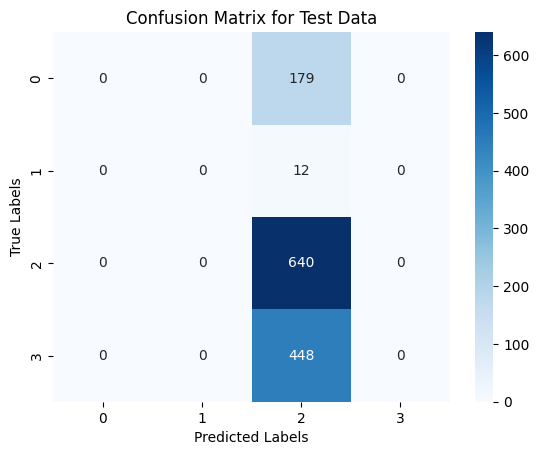

Test Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       179
           1       0.00      0.00      0.00        12
           2       0.50      1.00      0.67       640
           3       0.00      0.00      0.00       448

    accuracy                           0.50      1279
   macro avg       0.13      0.25      0.17      1279
weighted avg       0.25      0.50      0.33      1279



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix for test data
conf_mat_test = confusion_matrix(true_test_labels, predicted_test_labels)
print("Test Confusion Matrix:\n", conf_mat_test)

# Plotting the confusion matrix
sns.heatmap(conf_mat_test, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Test Data')
plt.show()

# Classification report for test data
cls_report_test = classification_report(true_test_labels, predicted_test_labels)
print("Test Classification Report:\n", cls_report_test)


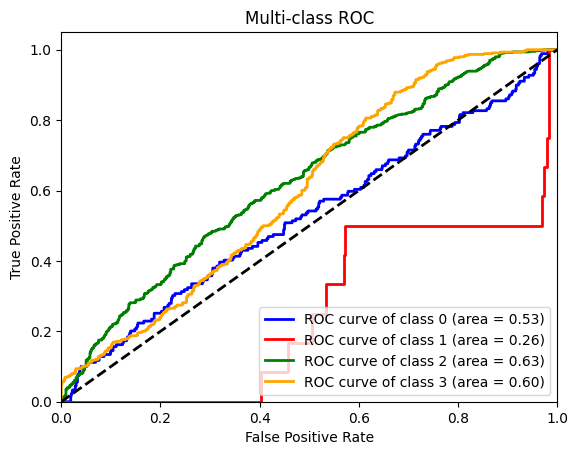

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Binarize labels for multi-class ROC
n_classes = len(np.unique(true_test_labels))
true_test_bin = label_binarize(true_test_labels, classes=np.arange(n_classes))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(true_test_bin[:, i], predicted_test_batches[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
colors = cycle(['blue', 'red', 'green', 'orange'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC')
plt.legend(loc="lower right")
plt.show()


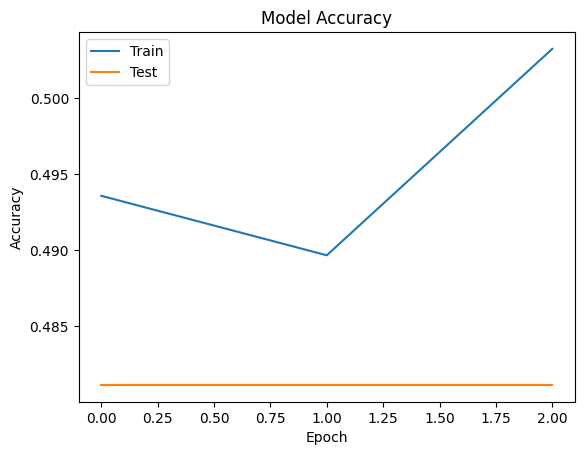

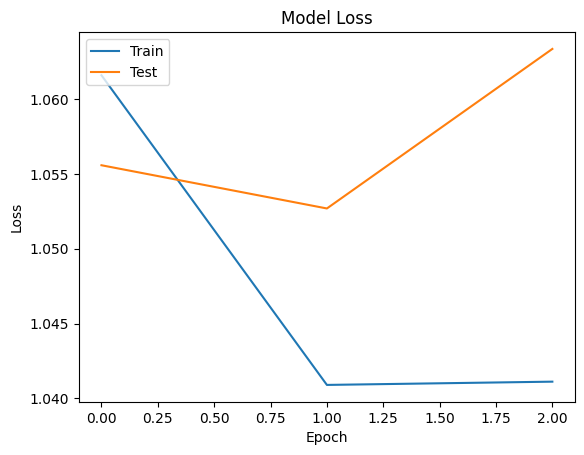

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
# Attempt 1: BigDL
# from pyspark.sql import SparkSession
# from bigdl.util.common import init_engine
# from bigdl.transform.vision.image import ImageFrame

# # Initialize Spark session and BigDL
# spark = SparkSession.builder \
#     .appName("Image Classification with PySpark and BigDL") \
#     .config("spark.driver.memory", "4g") \
#     .getOrCreate()
# init_engine()

# def load_images(image_directory):
#     # Ensure the path is correctly handled; no wildcard is needed if the directory contains only image files
#     image_frame = ImageFrame.read(image_directory, spark)
#     return image_frame

# # Adjust the path to point directly to the folder containing images, without wildcards if possible
# train_image_dir = "/content/dataset/Alzheimer_s Dataset/train"

# # Load images
# train_images = load_images(train_image_dir)
